# Imports 

In [1]:
import pandas
pandas.set_option("display.max_columns", None)
import numpy as np
import copy
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import tqdm
import sklearn.linear_model
import sklearn.preprocessing 
import sklearn.model_selection
import sklearn.metrics
import seaborn as sns

# Pull Oddsshark data for the season 2018 to 2021

# Create Columns for Odds Shark Result, including Actual and Shark Predictions for Margin(home), Total, Home Points, and Away Points

In [3]:
#SharkResult = copy.deepcopy(SharkResult.loc[SharkResult['HorA'] == "Home"])
SharkResult = pandas.read_csv("SharkResult_raw_2018_2021.csv")

months_cal = {'Jan': "01", 'Feb': "02", 'Mar': "03", 'Apr': "04", 'May': "05", 'Jun': "06", 'Jul': "07", 
          'Aug':"08", 'Sep':"09", 'Oct':"10", 'Nov':"11", 'Dec':"12"}
SharkResult['month'] =  SharkResult['Date'].apply(lambda date : months_cal[date[0:3]])
SharkResult['year'] = np.where(SharkResult['Date'].str.len() == 12, SharkResult['Date'].str[8:], SharkResult['Date'].str[7:])
SharkResult['day'] = np.where(SharkResult['Date'].str.len() == 12, SharkResult['Date'].str[4:6], "0" + SharkResult['Date'].str[4:5])
SharkResult['URL_ID'] = SharkResult['year'] + SharkResult['month'] + SharkResult['day'] + "0" + SharkResult['Team']

SharkResult['Home.Score'] = np.where(SharkResult['Result'] == "W", SharkResult['Score'].str.split("-").str[0],SharkResult['Score'].str.split("-").str[1]).astype('float')
SharkResult['Away.Score'] = np.where(SharkResult['Result'] == "L", SharkResult['Score'].str.split("-").str[0],SharkResult['Score'].str.split("-").str[1]).astype('float')
SharkResult['margin'] = SharkResult['Home.Score'] - SharkResult['Away.Score']
SharkResult['Total.Score'] = SharkResult['Home.Score'] + SharkResult['Away.Score']

SharkResult['shark.margin'] = -1*SharkResult['Spread'].astype('float')
SharkResult['shark.home_PTS'] = (SharkResult['Total'] + SharkResult['shark.margin']) / 2
SharkResult['shark.away_PTS'] = (SharkResult['Total'] - SharkResult['shark.margin']) / 2
SharkResult['shark.total_PTS'] = SharkResult['shark.home_PTS'] + SharkResult['shark.away_PTS']

SharkResult['shark.margin_error'] = SharkResult['shark.margin'] - SharkResult['margin']
SharkResult['shark.abs_margin_error'] = abs(SharkResult['shark.margin_error'])
SharkResult['shark.total_error'] = SharkResult['shark.total_PTS'] - SharkResult['Total.Score']
SharkResult['shark.abs_total_error'] = abs(SharkResult['shark.total_error'])

SharkResult['shark.home_PTS_error'] = SharkResult['shark.home_PTS'] - SharkResult['Home.Score']
SharkResult['shark.abs_home_PTS_error'] = abs(SharkResult['shark.home_PTS_error'])
SharkResult['shark.away_PTS_error'] = SharkResult['shark.away_PTS'] - SharkResult['Away.Score']
SharkResult['shark.abs_away_PTS_error'] = abs(SharkResult['shark.away_PTS_error'])

SR = SharkResult.loc[SharkResult['Game'] == "REG"].drop(['Date', 'Opponent', 'Game', 'Result', 'Score', 'ATS', 'Spread', 'OU', 'month', 'year', 'day', 'Total' ], axis = 1)

SR.to_csv("SharkResult_2018_2021.csv", index_label = False, index = False)

SR.sort_values(['Season', 'Team']).tail()

,Team,Season,GameNum,GameNumBand,HorA,URL_ID,Home.Score,Away.Score,margin,Total.Score,shark.margin,shark.home_PTS,shark.away_PTS,shark.total_PTS,shark.margin_error,shark.abs_margin_error,shark.total_error,shark.abs_total_error,shark.home_PTS_error,shark.abs_home_PTS_error,shark.away_PTS_error,shark.abs_away_PTS_error
4930,WAS,2021,61,>40,Home,202104260WAS,143.0,146.0,-3.0,289.0,-2.5,114.50,117.00,231.5,0.5,0.5,-57.5,57.5,-28.50,28.50,-29.00,29.00
4931,WAS,2021,62,>40,Home,202104280WAS,116.0,107.0,9.0,223.0,-1.0,114.50,115.50,230.0,-10.0,10.0,7.0,7.0,-1.50,1.50,8.50,8.50
4932,WAS,2021,65,>40,Home,202105030WAS,154.0,141.0,13.0,295.0,4.5,125.25,120.75,246.0,-8.5,8.5,-49.0,49.0,-28.75,28.75,-20.25,20.25
4933,WAS,2021,71,>40,Home,202105140WAS,120.0,105.0,15.0,225.0,9.0,117.75,108.75,226.5,-6.0,6.0,1.5,1.5,-2.25,2.25,3.75,3.75
4934,WAS,2021,72,>40,Home,202105160WAS,115.0,110.0,5.0,225.0,6.5,118.50,112.00,230.5,1.5,1.5,5.5,5.5,3.50,3.50,2.00,2.00


***
# Begin Looking at the performance of the odds shark predictions. 

- As expected, the mean errors are near zero. 
- The MAE is 9.97 for margin, 14.54 for total, 8.91 for home points, 8.88 for away points
- Margin error middlie 50% is (-8, 8.5). Absolute is (3.5, 14) 

In [4]:
SR.loc[:,(SR.columns.str.contains("error"))].describe()

,shark.margin_error,shark.abs_margin_error,shark.total_error,shark.abs_total_error,shark.home_PTS_error,shark.abs_home_PTS_error,shark.away_PTS_error,shark.abs_away_PTS_error
count,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000
mean,0.185040,9.977386,-0.519569,14.541531,-0.167265,8.907752,-0.352305,8.888617
std,12.838996,8.081101,18.385671,11.260586,11.260788,6.889705,11.163826,6.762430
min,-55.000000,0.000000,-99.000000,0.000000,-45.500000,0.000000,-53.500000,0.000000
25%,-8.000000,3.500000,-12.000000,6.000000,-7.250000,3.500000,-7.625000,3.500000
50%,0.000000,8.000000,0.000000,12.000000,0.000000,7.500000,-0.250000,7.500000
75%,8.500000,14.000000,12.000000,20.500000,7.750000,12.750000,7.250000,12.750000
max,54.000000,55.000000,58.500000,99.000000,41.750000,45.500000,40.500000,53.500000


In [5]:
print("Shark R2 score for margin:" + str(np.round(sklearn.metrics.r2_score(SR['margin'], SR['shark.margin']),5)))
print("Shark R2 score for Total_PTS:" + str(np.round(sklearn.metrics.r2_score(SR['Total.Score'], SR['shark.total_PTS']),5)))
print("Shark R2 score for home_PTS:" + str(np.round(sklearn.metrics.r2_score(SR['Home.Score'], SR['shark.home_PTS']),5)))
print("Shark R2 score for away_PTS:" + str(np.round(sklearn.metrics.r2_score(SR['Away.Score'], SR['shark.away_PTS']),5)))

Shark R2 score for margin:0.19791
Shark R2 score for Total_PTS:0.21222
Shark R2 score for home_PTS:0.19864
Shark R2 score for away_PTS:0.21649


In [6]:
SR['margin_abs_error_bucket'] = np.where(SR['shark.abs_margin_error'] <= 3, "(,3]", 
                                 np.where(SR['shark.abs_margin_error'] <= 6, "(3,6]",
                                 np.where(SR['shark.abs_margin_error'] <= 9, "(6,9]",
                                 np.where(SR['shark.abs_margin_error'] <= 12, "(9,12]",
                                 "[12,)"))))


SR.loc[:,['margin','margin_abs_error_bucket']].groupby('margin_abs_error_bucket').count()

,margin
margin_abs_error_bucket,
"(,3]",1016
"(3,6]",846
"(6,9]",674
"(9,12]",578
"[12,)",1485


### Comparison of how errors compare to the so-called Null God Predictions

In [7]:
SR['nullgod.abs_margin_error'] = abs(SR['margin'] - np.mean(SR['margin']))
SR['nullgod.abs_total_error'] = abs(SR['Total.Score'] - np.mean(SR['Total.Score']))
SR['nullgod.abs_home_error'] = abs(SR['Home.Score'] - np.mean(SR['Home.Score']))
SR['nullgod.abs_away_error'] = abs(SR['Away.Score'] - np.mean(SR['Away.Score']))
SR.loc[:,(SR.columns.str.contains("abs_"))].describe()

,shark.abs_margin_error,shark.abs_total_error,shark.abs_home_PTS_error,shark.abs_away_PTS_error,nullgod.abs_margin_error,nullgod.abs_total_error,nullgod.abs_home_error,nullgod.abs_away_error
count,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000
mean,9.977386,14.541531,8.907752,8.888617,11.377756,16.440770,10.004067,10.066601
std,8.081101,11.260586,6.889705,6.762430,8.722051,12.612735,7.626864,7.607008
min,0.000000,0.000000,0.000000,0.000000,0.003696,0.495543,0.249619,0.245923
25%,3.500000,6.000000,3.500000,3.500000,4.996304,6.504457,4.249619,3.754077
50%,8.000000,12.000000,7.500000,7.500000,9.003696,13.504457,8.249619,8.245923
75%,14.000000,20.500000,12.750000,12.750000,15.996304,23.504457,14.249619,14.754077
max,55.000000,99.000000,45.500000,53.500000,59.003696,108.504457,49.750381,58.754077


# LML Plots of Targets vs Y Hats

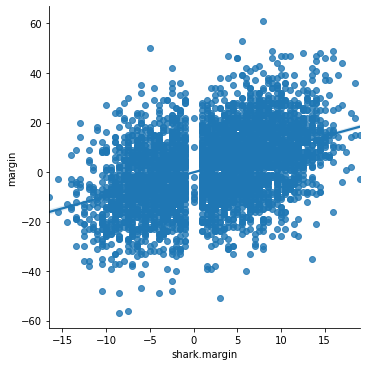

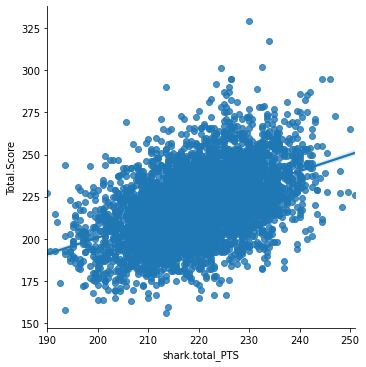

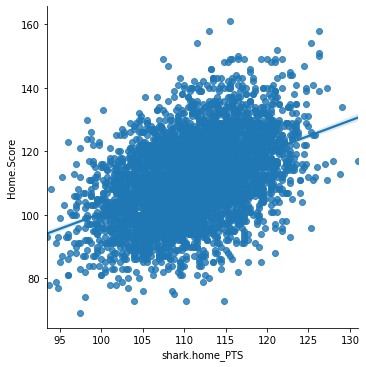

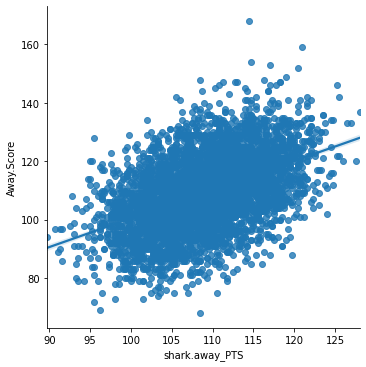

In [8]:
#sns.set(rc={'figure.figsize':(8,8)})
g = sns.lmplot(x="shark.margin", y="margin",
               data=SR, height=5)
g = sns.lmplot(x="shark.total_PTS", y="Total.Score",
               data=SR, height=5)
g = sns.lmplot(x="shark.home_PTS", y="Home.Score",
               data=SR, height=5)
g = sns.lmplot(x="shark.away_PTS", y="Away.Score",
               data=SR, height=5)

# PDF AND CDF OF ERROR 

<AxesSubplot:xlabel='shark.abs_margin_error', ylabel='Density'>

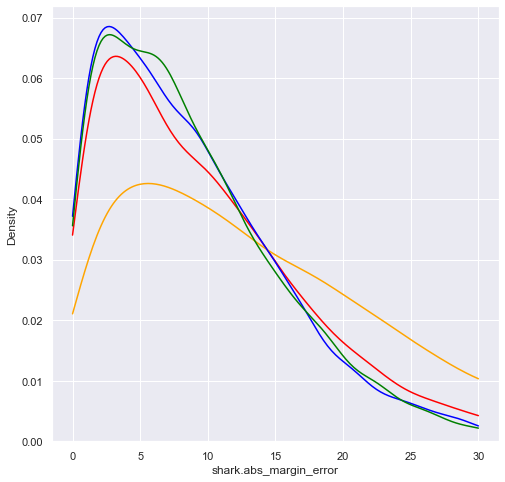

In [9]:
sns.set(rc={'figure.figsize':(8,8)})
sns.kdeplot(data = SR, x = "shark.abs_margin_error", common_norm = False, clip = (0,30), color = 'red')
sns.kdeplot(data = SR, x = "shark.abs_total_error", common_norm = False, clip = (0,30), color = 'orange')
sns.kdeplot(data = SR, x = "shark.abs_home_PTS_error", common_norm = False, clip = (0,30), color = 'blue')
sns.kdeplot(data = SR, x = "shark.abs_away_PTS_error", common_norm = False, clip = (0,30), color = 'green')

<AxesSubplot:xlabel='shark.abs_margin_error', ylabel='Density'>

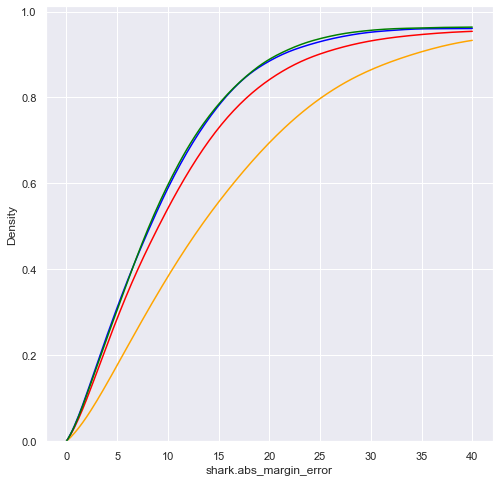

In [10]:
sns.set(rc={'figure.figsize':(8,8)})
sns.kdeplot(data = SR, x = "shark.abs_margin_error", common_norm = False, clip = (0,40), cumulative = True, color = 'red')
sns.kdeplot(data = SR, x = "shark.abs_total_error", common_norm = False, clip = (0,40), cumulative = True, color = 'orange')
sns.kdeplot(data = SR, x = "shark.abs_home_PTS_error", common_norm = False, clip = (0,40), cumulative = True, color = 'blue')
sns.kdeplot(data = SR, x = "shark.abs_away_PTS_error", common_norm = False, clip = (0,40), cumulative = True, color = 'green')

# PDF and CDF ofs of actual and predicted values

<AxesSubplot:xlabel='margin', ylabel='Density'>

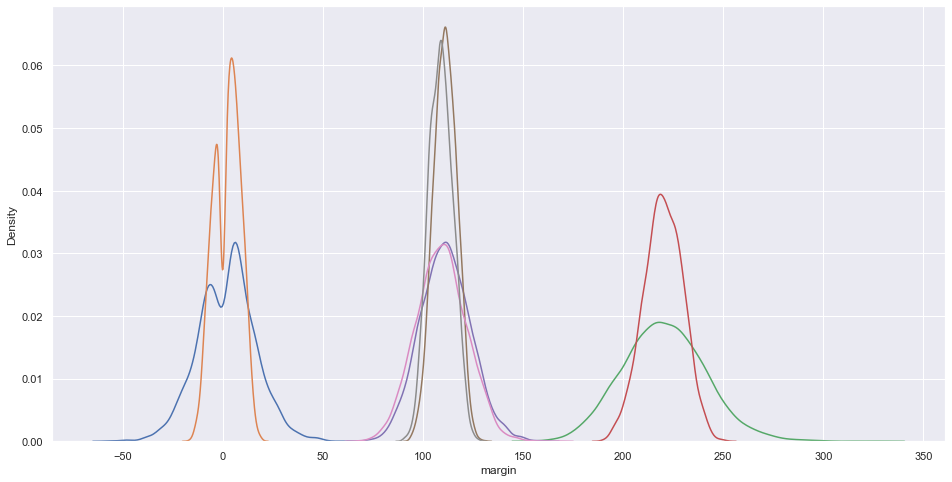

In [11]:
sns.set(rc={'figure.figsize':(16,8)})
sns.kdeplot(data = SR, x = "margin", common_norm = False)
sns.kdeplot(data = SR, x = "shark.margin",  common_norm = False)

sns.kdeplot(data = SR, x = "Total.Score", common_norm = False)
sns.kdeplot(data = SR, x = "shark.total_PTS",  common_norm = False)

sns.kdeplot(data = SR, x = "Home.Score", common_norm = False)
sns.kdeplot(data = SR, x = "shark.home_PTS",  common_norm = False)

sns.kdeplot(data = SR, x = "Away.Score", common_norm = False)
sns.kdeplot(data = SR, x = "shark.away_PTS",  common_norm = False)

<AxesSubplot:xlabel='margin', ylabel='Density'>

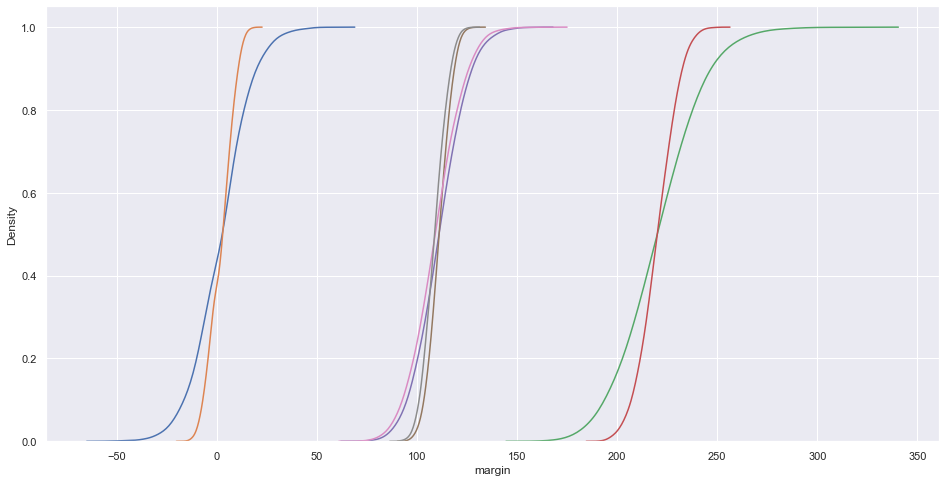

In [12]:
sns.set(rc={'figure.figsize':(16,8)})
sns.kdeplot(data = SR, x = "margin", common_norm = False, cumulative = True)
sns.kdeplot(data = SR, x = "shark.margin",  common_norm = False, cumulative = True)

sns.kdeplot(data = SR, x = "Total.Score", common_norm = False, cumulative = True)
sns.kdeplot(data = SR, x = "shark.total_PTS",  common_norm = False, cumulative = True)

sns.kdeplot(data = SR, x = "Home.Score", common_norm = False, cumulative = True)
sns.kdeplot(data = SR, x = "shark.home_PTS",  common_norm = False, cumulative = True)
sns.kdeplot(data = SR, x = "Away.Score", common_norm = False, cumulative = True)
sns.kdeplot(data = SR, x = "shark.away_PTS",  common_norm = False, cumulative = True)
#plt.xlim(-20,20)

### A More Specific look at how the predict margin compares to actual

<AxesSubplot:xlabel='margin', ylabel='Count'>

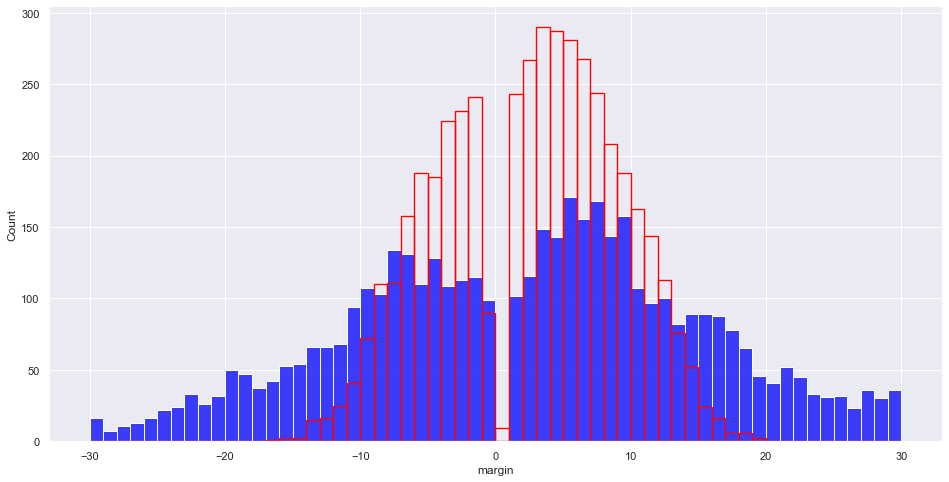

In [13]:
sns.histplot(data = SR, x = 'margin', color = 'blue', binwidth = 1, binrange = (-30,30))
sns.histplot(data = SR, x = 'shark.margin', fill = False, color = 'red', binwidth = 1, binrange = (-30,30))

*** 
# ANALYSIS BY SEASON

- The errors are similar for each season, though 2021 is notably quite higher. Lowest is 2018 at 9.45, 2019 and 2020 at 9.9, 2021 at 10.7
- Total error at similar at mean ~14.5 each year. 

In [14]:
SR.loc[:,(SR.columns.str.contains("shark.abs_")) | (SR.columns.str.contains("Season"))].groupby('Season').describe()

shark.abs_margin_error                                                  \
                        count       mean       std  min  25%  50%   75%   max   
Season                                                                          
2018                   1230.0   9.458130  7.779226  0.0  3.5  7.5  13.5  53.0   
2019                   1230.0   9.926829  8.123233  0.0  4.0  8.0  14.0  55.0   
2020                   1059.0   9.899433  8.051086  0.0  3.5  8.0  14.5  41.0   
2021                   1080.0  10.702778  8.354245  0.0  4.0  9.0  15.0  54.0   

       shark.abs_total_error                                                \
                       count       mean        std  min  25%   50%     75%   
Season                                                                       
2018                  1230.0  14.443902  10.767709  0.0  6.0  12.5  20.875   
2019                  1230.0  14.506911  11.787434  0.0  5.5  11.5  20.500   
2020                  1059.0  14.867800  11.343160  0.0  6.0  12.5  21.000   
2021                  1080.0  14.372222  11.122657  0.0  6.0  12.0  20.000   

             shark.abs_home_PTS_error                                        \
         max                    count      mean       std  min   25%    50%   
Season                                                                        
2018    76.5                   1230.0  8.552236  6.476931  0.0  3.25  7.625   
2019    99.0                   1230.0  9.003862  7.169944  0.0  3.25  7.500   
2020    83.0                   1059.0  8.946412  7.132880  0.0  3.50  7.250   
2021    60.5                   1080.0  9.165278  6.769832  0.0  3.75  7.875   

                       shark.abs_away_PTS_error                                \
            75%    max                    count      mean       std  min  25%   
Season                                                                          
2018    12.2500  41.50                   1230.0  8.787602  6.704986  0.0  3.5   
2019    13.1875  45.50                   1230.0  8.830691  6.819019  0.0  3.5   
2020    12.5000  45.00                   1059.0  9.085694  6.542154  0.0  4.0   
2021    13.0000  41.75                   1080.0  8.876389  6.977340  0.0  3.5   

                            
         50%    75%    max  
Season                      
2018    7.25  12.75  39.50  
2019    7.50  12.50  53.50  
2020    7.75  12.75  38.00  
2021    7.25  12.75  39.25

In [15]:
print("Shark R2 score for 2018 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['Season'] == 2018,'margin'], SR.loc[SR['Season'] == 2018,'shark.margin']),5)))
print("Shark R2 score for 2019 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['Season'] == 2019,'margin'], SR.loc[SR['Season'] == 2019,'shark.margin']),5)))
print("Shark R2 score for 2020 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['Season'] == 2020,'margin'], SR.loc[SR['Season'] == 2020,'shark.margin']),5)))
print("Shark R2 score for 2021 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['Season'] == 2021,'margin'], SR.loc[SR['Season'] == 2021,'shark.margin']),5)))

Shark R2 score for 2018 margin: 0.19525
Shark R2 score for 2019 margin: 0.20693
Shark R2 score for 2020 margin: 0.18019
Shark R2 score for 2021 margin: 0.20001


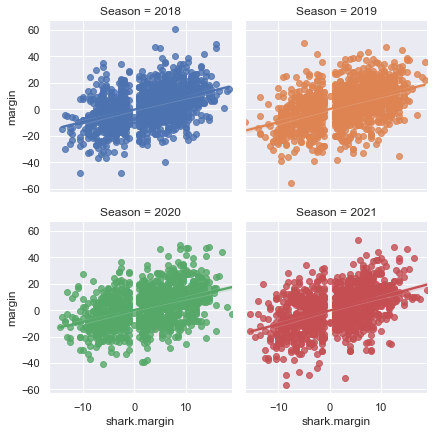

In [16]:
g = sns.lmplot(x="shark.margin", y="margin", col="Season", hue="Season",
               data=SR, col_wrap=2, height=3)

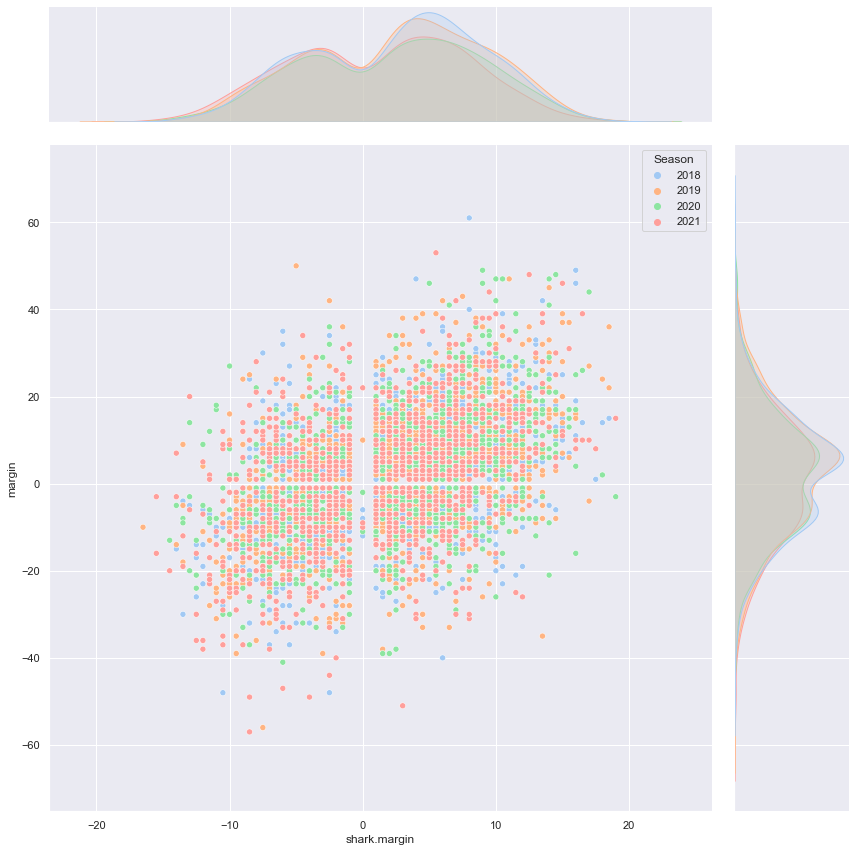

In [17]:
sns.set(rc={'figure.figsize':(16,16)})
#sns.kdeplot(data = SR, x = "shark.abs_margin_error", common_norm = False, clip = (0,30),hue = "Season")
sns.jointplot(data = SR, x = 'shark.margin', y = 'margin', hue = "Season", palette = sns.color_palette("pastel",4), height = 12)

*** 
# ANALYSIS BY Game Number

- As somewhat expected, the errors decrease as Game Num increases. 10.6 in the first 10 games, 9.79 in 40+
- Note: The should include the lower limit of previous band upper limit

In [18]:
SR.loc[:,(SR.columns.str.contains("shark.abs_")) | (SR.columns.str.contains("GameNumBand"))].groupby('GameNumBand').describe()

shark.abs_margin_error                                            \
                             count       mean       std  min  25%  50%   75%   
GameNumBand                                                                    
<=10                         595.0  10.551261  8.078444  0.0  4.5  9.0  15.0   
<=25                         912.0  10.130482  8.299086  0.0  4.0  8.0  14.5   
<=40                         899.0   9.894883  7.983092  0.0  3.5  8.5  14.0   
>40                         2193.0   9.791838  8.026820  0.0  3.5  8.0  14.0   

                  shark.abs_total_error                                        \
              max                 count       mean        std  min  25%   50%   
GameNumBand                                                                     
<=10         54.0                 595.0  15.327731  11.368935  0.0  6.5  12.5   
<=25         55.0                 912.0  14.759320  10.671058  0.0  6.5  13.0   
<=40         48.5                 899.0  13.835929  11.022050  0.0  5.5  11.0   
>40          53.0                2193.0  14.526904  11.552876  0.0  6.0  12.0   

                        shark.abs_home_PTS_error                           \
              75%   max                    count      mean       std  min   
GameNumBand                                                                 
<=10         22.0  83.0                    595.0  9.256303  7.107287  0.0   
<=25         21.0  58.5                    912.0  8.987664  6.830293  0.0   
<=40         19.5  68.5                    899.0  8.644049  6.549705  0.0   
>40          20.5  99.0                   2193.0  8.888053  6.989557  0.0   

                                        shark.abs_away_PTS_error            \
              25%   50%      75%    max                    count      mean   
GameNumBand                                                                  
<=10         3.75  8.00  13.5000  45.00                    595.0  9.440336   
<=25         3.75  7.75  12.5625  39.00                    912.0  8.852796   
<=40         3.50  7.50  12.5000  37.25                    899.0  8.699110   
>40          3.25  7.50  12.7500  45.50                   2193.0  8.831509   

                                                    
                  std  min  25%   50%    75%   max  
GameNumBand                                         
<=10         6.713849  0.0  4.0  8.25  13.25  38.0  
<=25         6.767823  0.0  3.5  7.25  12.75  40.5  
<=40         6.631695  0.0  3.5  7.00  12.50  36.5  
>40          6.823220  0.0  3.5  7.50  12.50  53.5

In [19]:
print("Shark R2 score for Games 1-10 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['GameNumBand'] == "<=10",'margin'], SR.loc[SR['GameNumBand'] == "<=10",'shark.margin']),5)))
print("Shark R2 score for Games 11 to 25 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['GameNumBand'] == "<=25",'margin'], SR.loc[SR['GameNumBand'] == "<=25",'shark.margin']),5)))
print("Shark R2 score for Games 26 to 40 margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['GameNumBand'] == "<=40",'margin'], SR.loc[SR['GameNumBand'] == "<=40",'shark.margin']),5)))
print("Shark R2 score for Games 40+ margin: " + str(np.round(sklearn.metrics.r2_score(SR.loc[SR['GameNumBand'] == ">40",'margin'], SR.loc[SR['GameNumBand'] == ">40",'shark.margin']),5)))

Shark R2 score for Games 1-10 margin: 0.13668
Shark R2 score for Games 11 to 25 margin: 0.20591
Shark R2 score for Games 26 to 40 margin: 0.15816
Shark R2 score for Games 40+ margin: 0.22434


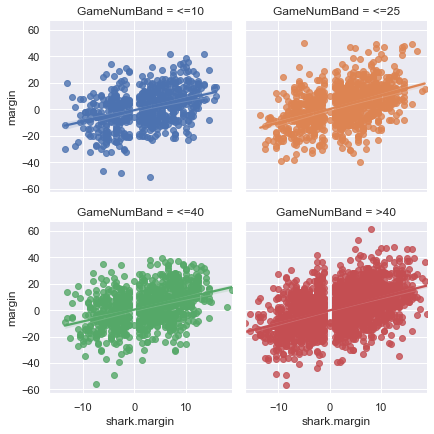

In [20]:
g = sns.lmplot(x="shark.margin", y="margin", col="GameNumBand", hue="GameNumBand",
               data=SR, col_wrap=2, height=3)

<AxesSubplot:xlabel='shark.abs_total_error', ylabel='Density'>

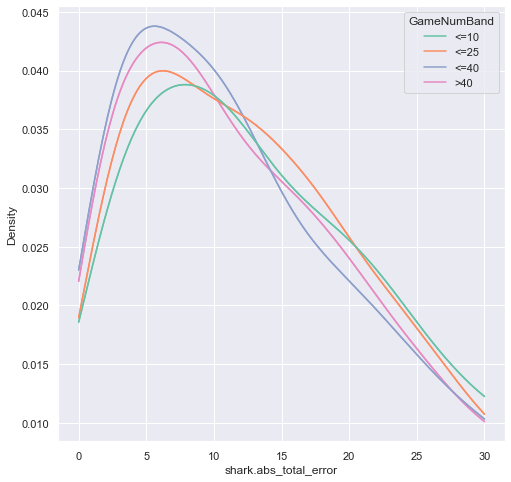

In [21]:
sns.set(rc={'figure.figsize':(8,8)})
sns.kdeplot(data = SR, x = "shark.abs_total_error", common_norm = False, clip = (0,30),hue = "GameNumBand", palette = sns.color_palette("Set2", 4))
sns.kdeplot(data = SR, x = "shark.abs_total_error", common_norm = False, clip = (0,30),hue = "GameNumBand", palette = sns.color_palette("Set2", 4))

*** 
# ANALYSIS BY Team, Just for Fun

- Most accurate team is was POR, with mean of 8.5 and MedAE of 6. Pretty impressive. PHIlly was also good
- GSW had highest mean error at 11.8. Probably from shitting on kids. UTA, ORL, CLE, ATL, and more also high

In [22]:
SR.loc[:,(SR.columns.str.contains("shark.abs_")) | (SR.columns.str.contains("Team"))].groupby('Team').describe()

shark.abs_margin_error                                                  \
                      count       mean       std  min    25%    50%     75%   
Team                                                                          
ATL                   152.0  10.434211  8.006348  0.0  4.000   9.50  13.625   
BOS                   154.0   9.983766  7.656092  0.0  4.000   8.50  14.500   
BRK                   154.0  10.142857  8.860892  0.0  3.625   8.00  13.000   
CHI                   152.0   9.815789  8.018126  0.0  3.500   8.50  14.000   
CHO                   149.0   9.416107  7.814013  0.0  4.000   7.50  13.500   
CLE                   154.0  10.938312  8.681234  0.0  3.625   9.25  15.875   
DAL                   156.0  10.535256  9.436394  0.0  3.500   8.50  14.125   
DEN                   155.0   8.954839  7.241288  0.0  3.250   7.00  12.500   
DET                   151.0  10.023179  7.619785  0.0  3.500   9.00  14.000   
GSW                   152.0  11.842105  9.706354  0.0  4.500   9.00  18.125   
HOU                   154.0  10.600649  8.131151  0.0  5.000   8.00  15.500   
IND                   154.0   9.743506  7.979188  0.0  3.500   7.50  13.500   
LAC                   154.0  10.649351  8.694362  0.5  4.500   9.00  14.750   
LAL                   153.0   9.545752  6.558281  0.0  4.500   8.50  14.000   
MEM                   155.0   9.341935  7.364524  0.0  4.000   7.00  13.000   
MIA                   154.0  10.185065  8.253332  0.0  4.000   8.25  15.000   
MIL                   153.0   9.627451  8.438541  0.0  3.000   6.50  14.500   
MIN                   150.0   9.806667  7.639044  0.0  3.500   8.50  13.000   
NOP                   154.0   9.711039  7.533972  0.0  3.125   8.50  14.500   
NYK                   151.0   9.817881  7.742412  0.0  3.500   8.50  15.000   
OKC                   155.0  10.180645  7.823517  0.0  4.500   8.50  14.500   
ORL                   153.0  11.294118  9.251516  0.0  3.500  10.50  16.000   
PHI                   153.0   8.630719  7.916873  0.0  2.500   6.00  12.500   
PHO                   157.0  10.560510  8.660134  0.0  4.500   8.00  16.500   
POR                   154.0   8.500000  7.734778  0.0  3.000   6.00  12.875   
SAC                   153.0   8.754902  7.016456  0.0  3.000   7.00  12.500   
SAS                   152.0  10.565789  8.062193  0.0  4.000   9.00  14.500   
TOR                   154.0   9.237013  8.170207  0.0  3.500   6.50  12.500   
UTA                   153.0  11.156863  8.669265  0.0  4.000   9.50  15.000   
WAS                   154.0   9.321429  6.270243  0.0  5.000   8.25  12.875   

           shark.abs_total_error                                           \
       max                 count       mean        std  min    25%    50%   
Team                                                                        
ATL   41.0                 152.0  16.776316  13.307468  0.0  7.875  14.00   
BOS   37.0                 154.0  15.438312  12.230671  0.5  6.000  11.75   
BRK   41.0                 154.0  14.847403  12.641917  0.0  5.500  11.00   
CHI   48.5                 152.0  14.016447  11.102833  0.0  5.875  11.75   
CHO   53.0                 149.0  13.862416  10.813196  0.0  4.500  12.00   
CLE   35.0                 154.0  14.051948  11.936128  0.0  5.000  12.50   
DAL   55.0                 156.0  15.391026  11.822381  0.0  6.500  13.25   
DEN   32.0                 155.0  15.354839  10.999552  0.0  6.750  12.50   
DET   41.5                 151.0  13.178808   9.722199  0.5  5.500  11.00   
GSW   48.5                 152.0  14.115132  11.753042  0.0  5.500  10.75   
HOU   45.0                 154.0  15.243506  12.249882  0.0  6.500  12.00   
IND   44.5                 154.0  14.211039  10.304797  0.0  6.500  12.25   
LAC   54.0                 154.0  13.805195  10.965232  0.0  5.500  11.50   
LAL   31.5                 153.0  15.013072  11.090825  0.0  6.500  12.00   
MEM   36.0                 155.0  14.493548  12.052643  0.0  5.000  11.00   
MIA   41.0 

# Plot The absolute erros for Total and Margin. 
# PLot the error and absolute errors for Margin
# LML Plot for every team

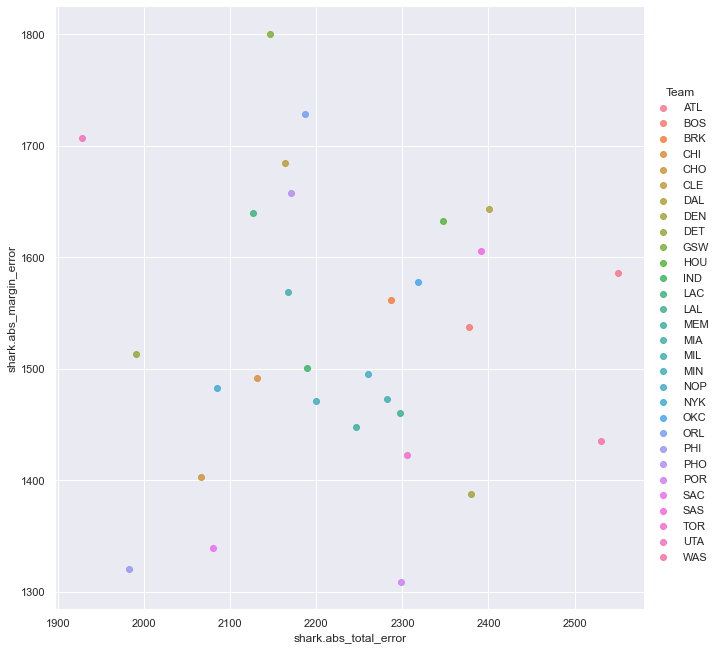

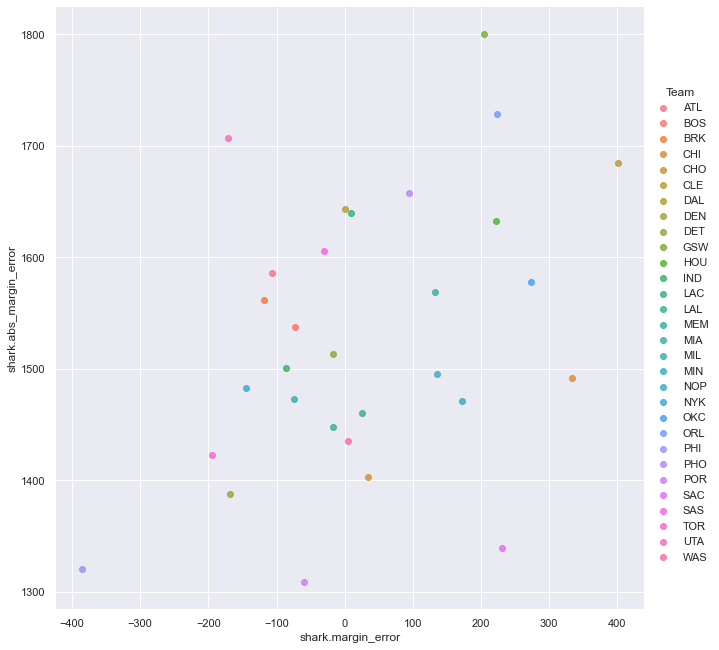

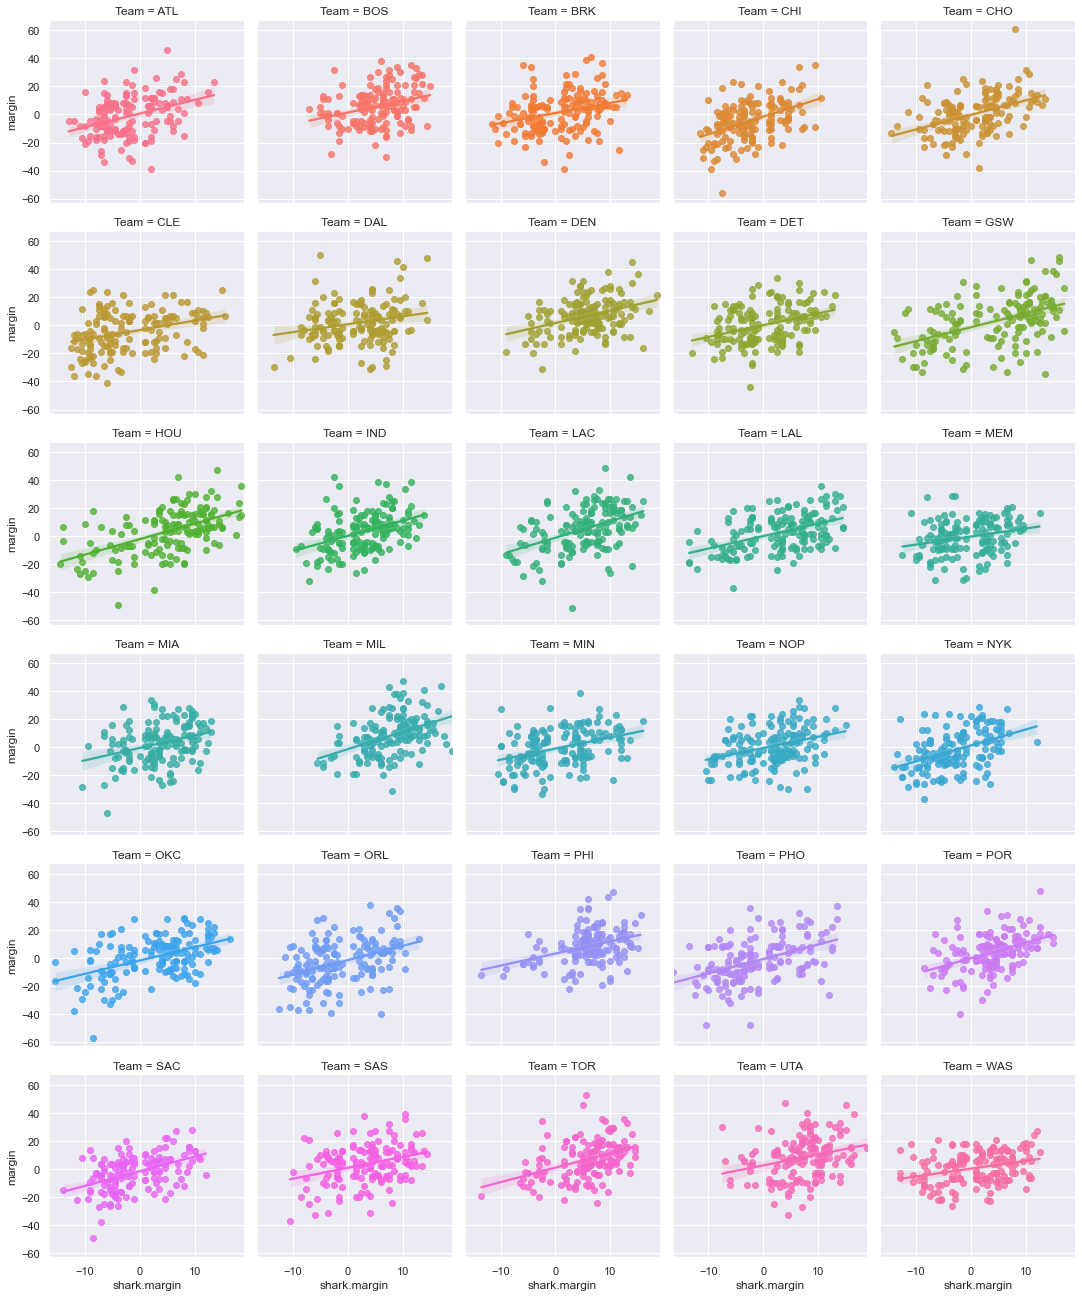

In [23]:
g = sns.lmplot(x="shark.abs_total_error", y="shark.abs_margin_error", hue="Team",
               data=SR.groupby('Team', as_index=False).sum(), height=9)
g2 = sns.lmplot(x="shark.margin_error", y="shark.abs_margin_error", hue="Team",
               data=SR.groupby('Team', as_index=False).sum(), height=9)

g3 = sns.lmplot(x="shark.margin", y="margin", col="Team", hue="Team",
               data=SR, col_wrap=5, height=3)
